# Python Dependencies

In [848]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import os
from tensorflow.keras import layers
import time
import kaggle
from scipy.fft import fft, fftfreq, ifft

# Defining Constants

In [849]:
# Defining constants
PATH = 'data/'
TRAIN_CSV = PATH + 'train.csv'
TEST_CSV = PATH + 'test.csv'
SUBMISSION_CSV = PATH + 'submission.csv'
TEST_EEGS = PATH + 'test_eegs/'
TRAIN_EEGS = PATH + 'train_eegs/'
TEST_SPECTROGRAMS = PATH + 'test_spectrograms/'
TRAIN_SPECTROGRAMS = PATH + 'train_spectrograms/'

# Defining the duration time for eeg and spectrogram respectively
eeg_duration = 10000
spectrogram_duration = 300

eeg_time = 50
spectrogram_time = 10 * 60


# Fourier General Function

In [850]:
# Assumption:   - The eeg_data is a 1D numpy array
#               - The eeg_data is a time series data
#               - The eeg_data comprises of sums of sine or cosine waves (with a little bit of noise)

# This function takes in an EEG data and plots the original signal, calculates the fourier transform and plots the 
# filtered signal.

# fourier_transform_eeg(eeg_data :: np.array, level_of_detail :: int): 
#                           np.array, int -> np.array(2, level_of_detail)

def fourier_transform_eeg(eeg_data, level_of_detail=10):
    # Creating a list to store the filtered signals
    filtered_signals = [[],[]]

    for i in range(eeg_data.shape[0]):
        # Taking the Fourier transform of the signal
        eeg_data_fft = fft(eeg_data[i])

        amplitude = eeg_data_fft.real
        frequency = fftfreq(len(eeg_data[i]))

        peak_indicies = np.argsort(amplitude)[-level_of_detail:]
        amplitude = amplitude[peak_indicies]
        frequency = frequency[peak_indicies]

        filtered_signals[0].append(amplitude)
        filtered_signals[1].append(frequency)

    return filtered_signals

In [851]:
def visualize_inverse_fourier(transformed_eeg_data):
    nx = 5
    ny = 4

    figure, axis = plt.subplots(nx, ny, figsize=(20, 20))
    figure.supxlabel("Time(s)")
    figure.supylabel("Voltage (micro volts)")

    for i in range(transformed_eeg_data.shape[1]):
        # Reconstructing the filtered signal using the inverse Fourier transform
        amplitude_and_frequency = transformed_eeg_data[:,i]
        sin_wave_sum_list = np.zeros(eeg_duration)

        for j in range(amplitude_and_frequency.shape[1]):
            amplitude = amplitude_and_frequency[0][j]
            frequency = amplitude_and_frequency[1][j]


            print(amplitude, frequency)
            if (frequency == 0):
                sin_wave = amplitude 
            else:
                sin_wave = np.sin(2 * np.pi * np.arange(0, eeg_duration) / frequency )
            
            sin_wave_sum_list = np.add(sin_wave_sum_list, sin_wave)

        
        axis[i // ny, i % ny].plot(sin_wave_sum_list, 
                                    label="Filtered Signal", 
                                    color="blue")

    plt.show()

In [852]:
def visualize_eeg(eeg_data):
    nx = 5
    ny = 4

    figure, axis = plt.subplots(nx, ny, figsize=(20, 20))
    figure.supxlabel("Time(s)")
    figure.supylabel("Voltage (micro volts)")

    for i in range(eeg_data.shape[0]):
        axis[i // ny, i % ny].plot(eeg_data[i], 
                                    label="Filtered Signal", 
                                    color="red")

    plt.show()

# Loading One Sample Data

In [853]:
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)

eeg_id = train['eeg_id'][0]
spectrogram_id = train['spectrogram_id'][0]

eeg_offset = train['eeg_label_offset_seconds'][0]
spectrogram_offset = train['spectrogram_label_offset_seconds'][0]

eeg = pd.read_parquet(f'{TRAIN_EEGS}{eeg_id}.parquet').loc[eeg_offset : eeg_offset + eeg_duration - 1,]
eeg = eeg.T.to_numpy()

spectrogram = pd.read_parquet(f'{TRAIN_SPECTROGRAMS}{spectrogram_id}.parquet').loc[spectrogram_offset : spectrogram_offset + spectrogram_duration - 1,]
spectrogram = spectrogram.T.to_numpy()

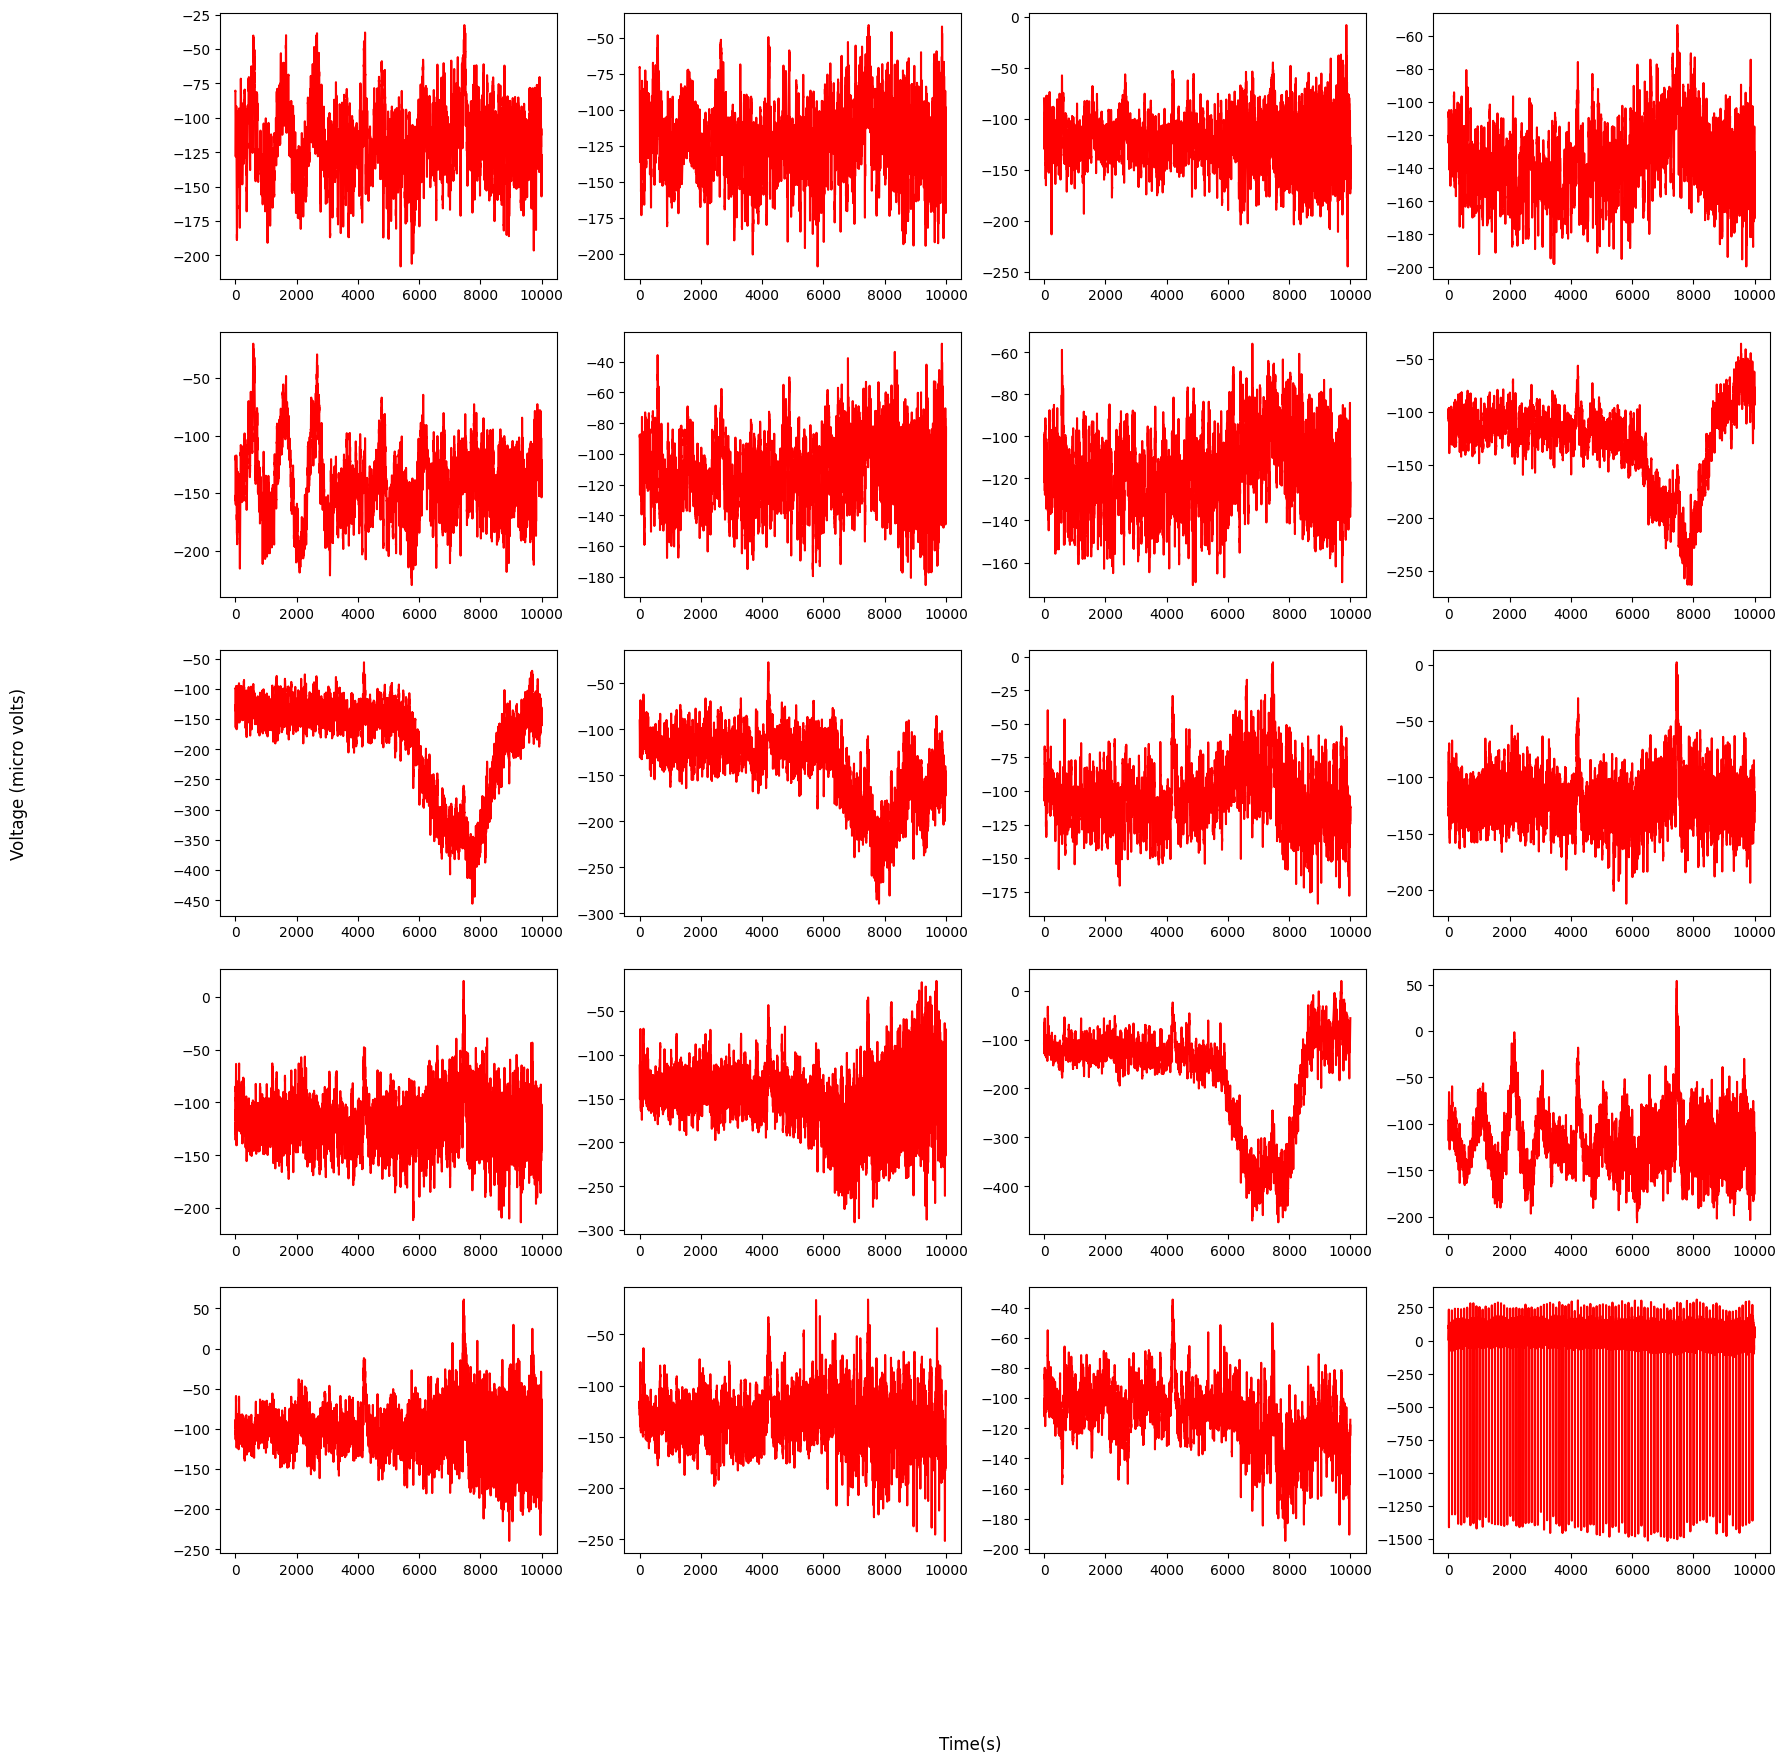

In [854]:
visualize_eeg(eeg)

Size of transformed list:  40000
Shape of transformed list:  (2, 20, 1000)
592.5997314453125 0.08650000000000001
592.5997314453125 -0.08650000000000001
594.7413330078125 -0.41050000000000003
594.7413330078125 0.41050000000000003
595.349609375 -0.3865
595.349609375 0.3865
596.4902954101562 -0.0721
596.4902954101562 0.0721
597.5289916992188 -0.13140000000000002
597.5289916992188 0.13140000000000002
597.57958984375 -0.2504
597.57958984375 0.2504
598.3286743164062 -0.42110000000000003
598.3286743164062 0.42110000000000003
599.6735229492188 0.2082
599.6735229492188 -0.2082
602.96923828125 -0.0741
602.96923828125 0.0741
603.1748046875 0.0776
603.1748046875 -0.0776
603.2236938476562 0.27940000000000004
603.2236938476562 -0.27940000000000004
605.2351684570312 -0.1061
605.2351684570312 0.1061
606.6329345703125 -0.12000000000000001
606.6329345703125 0.12000000000000001
606.8828125 -0.0794
606.8828125 0.0794
608.4773559570312 0.1308
608.4773559570312 -0.1308
614.4414672851562 -0.26780000000000004

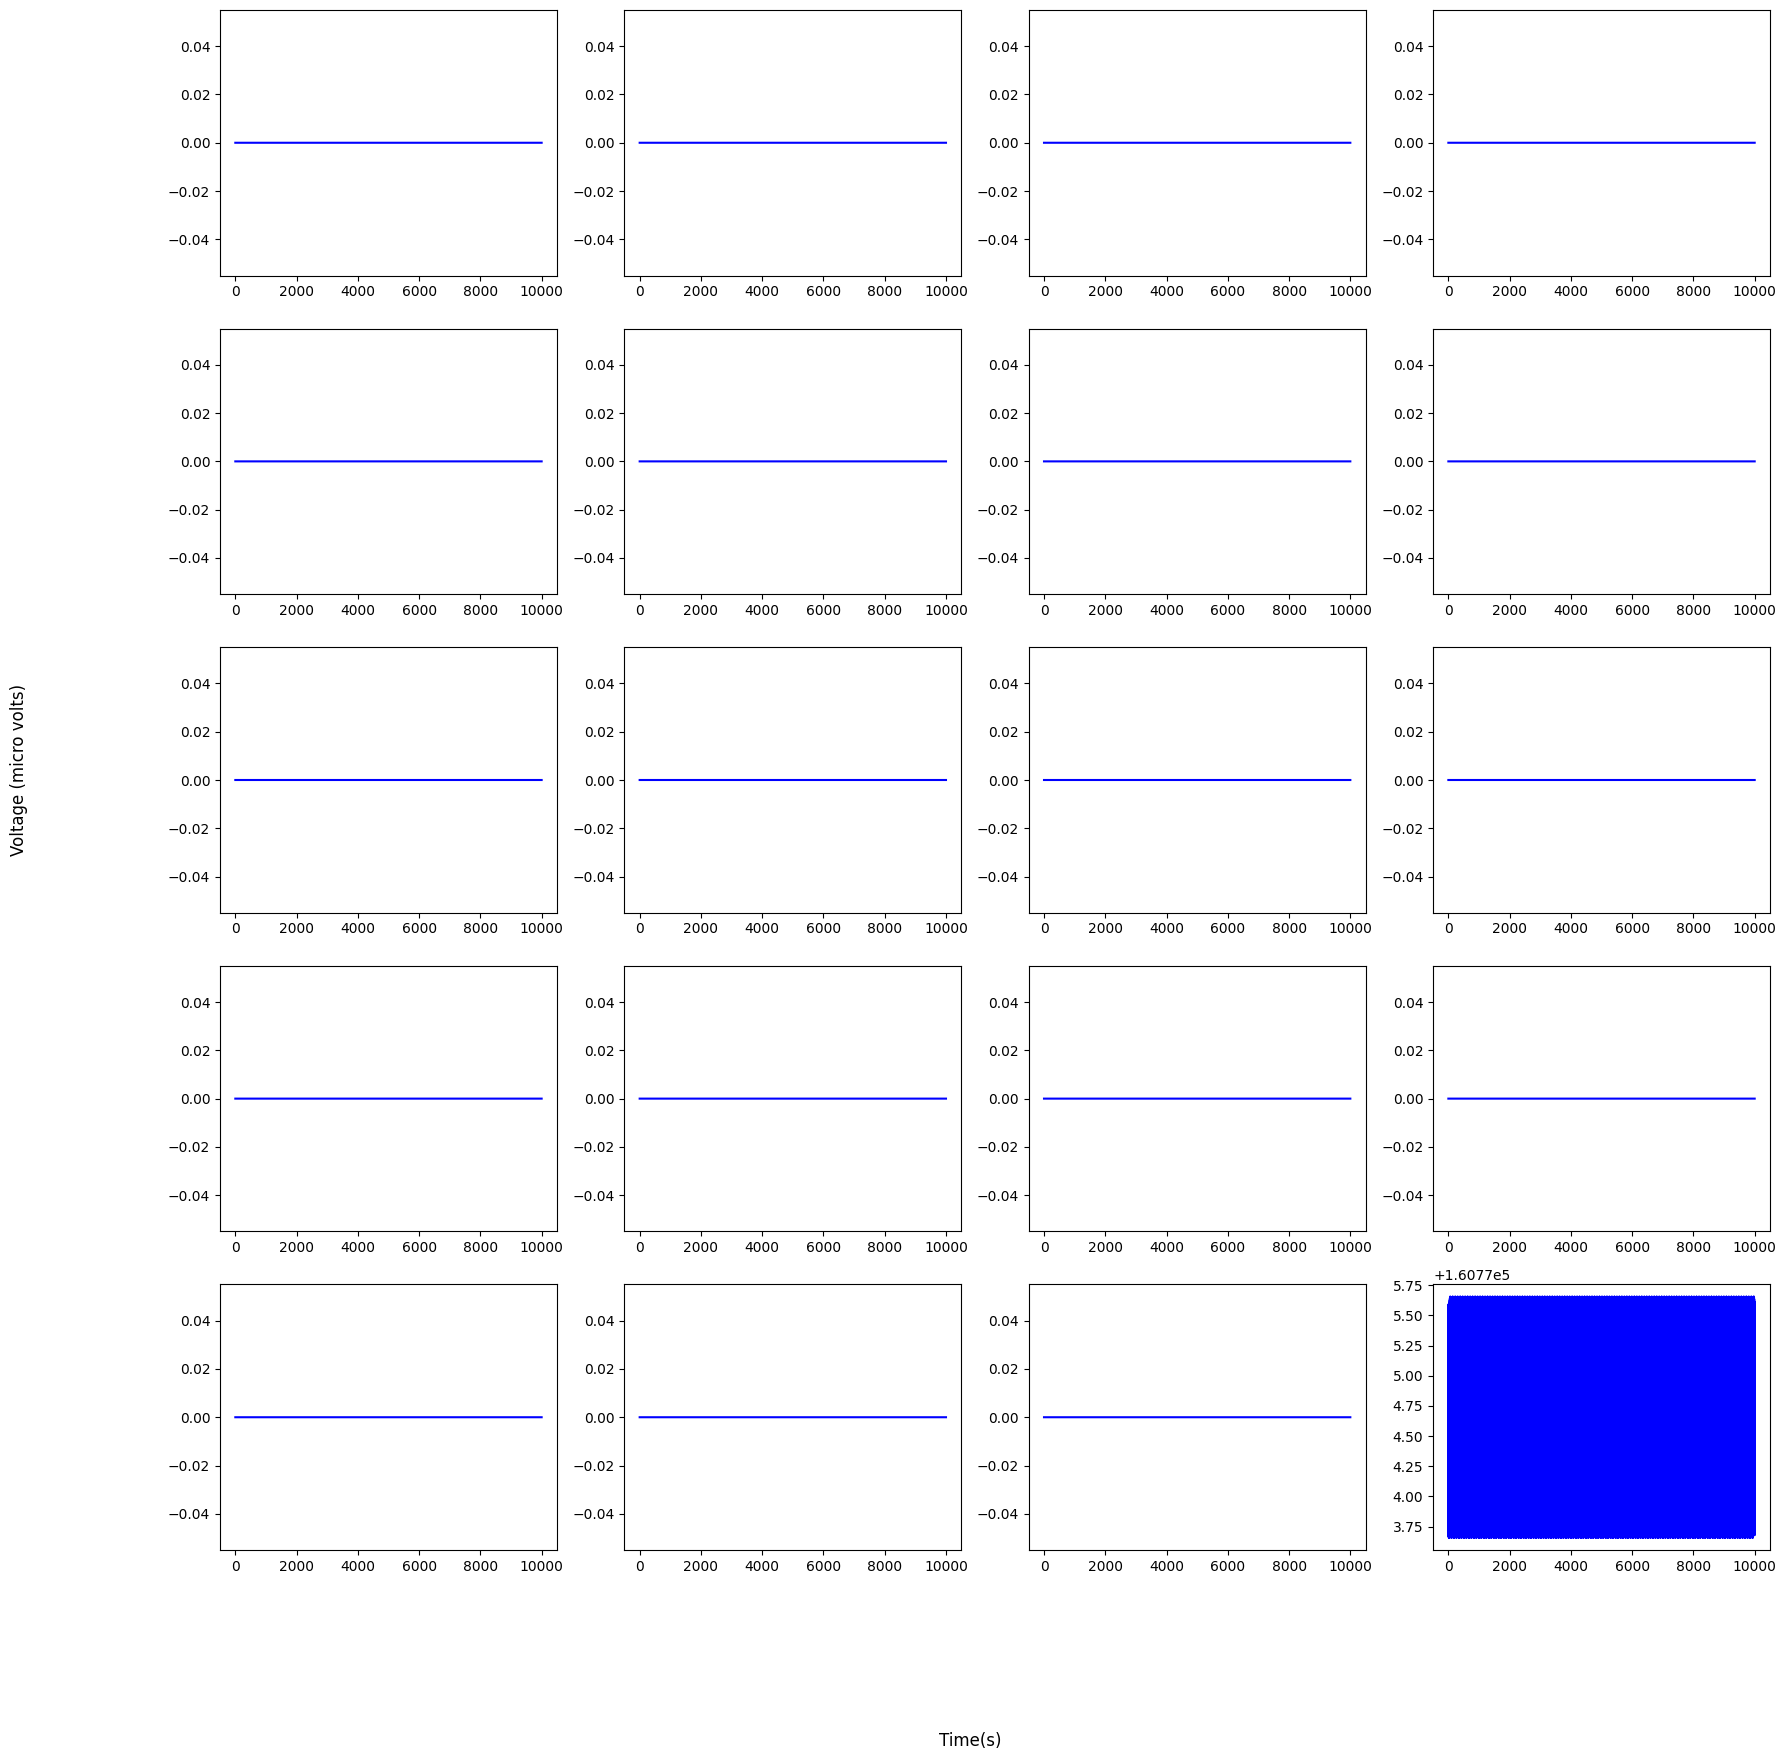

In [855]:
detail = 1000

sample_eeg_fourier_list =  fourier_transform_eeg(eeg, detail)
sample_eeg_fourier_list = np.array(sample_eeg_fourier_list)

print("Size of transformed list: ", sample_eeg_fourier_list.size)
print("Shape of transformed list: ", sample_eeg_fourier_list.shape)

visualize_inverse_fourier(sample_eeg_fourier_list)


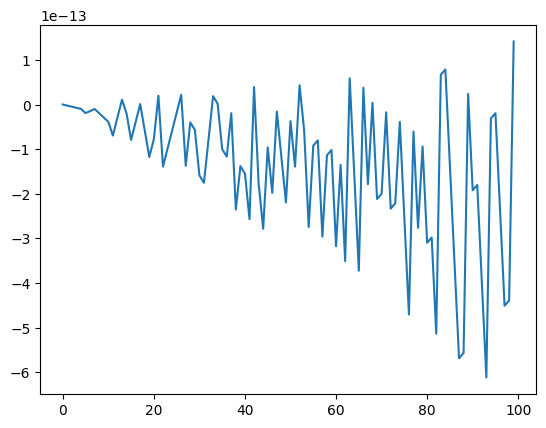

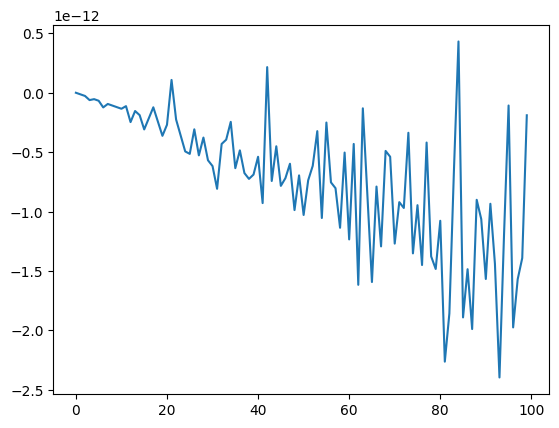

2.170195006980305e-12 0.38
2.170195006980305e-12 -0.38
3.499233022601309e-12 0.19
3.499233022601309e-12 -0.19
6.852428353100816e-12 -0.18
6.852428353100816e-12 0.18
8.712151924490761e-12 0.19
8.712151924490761e-12 -0.19


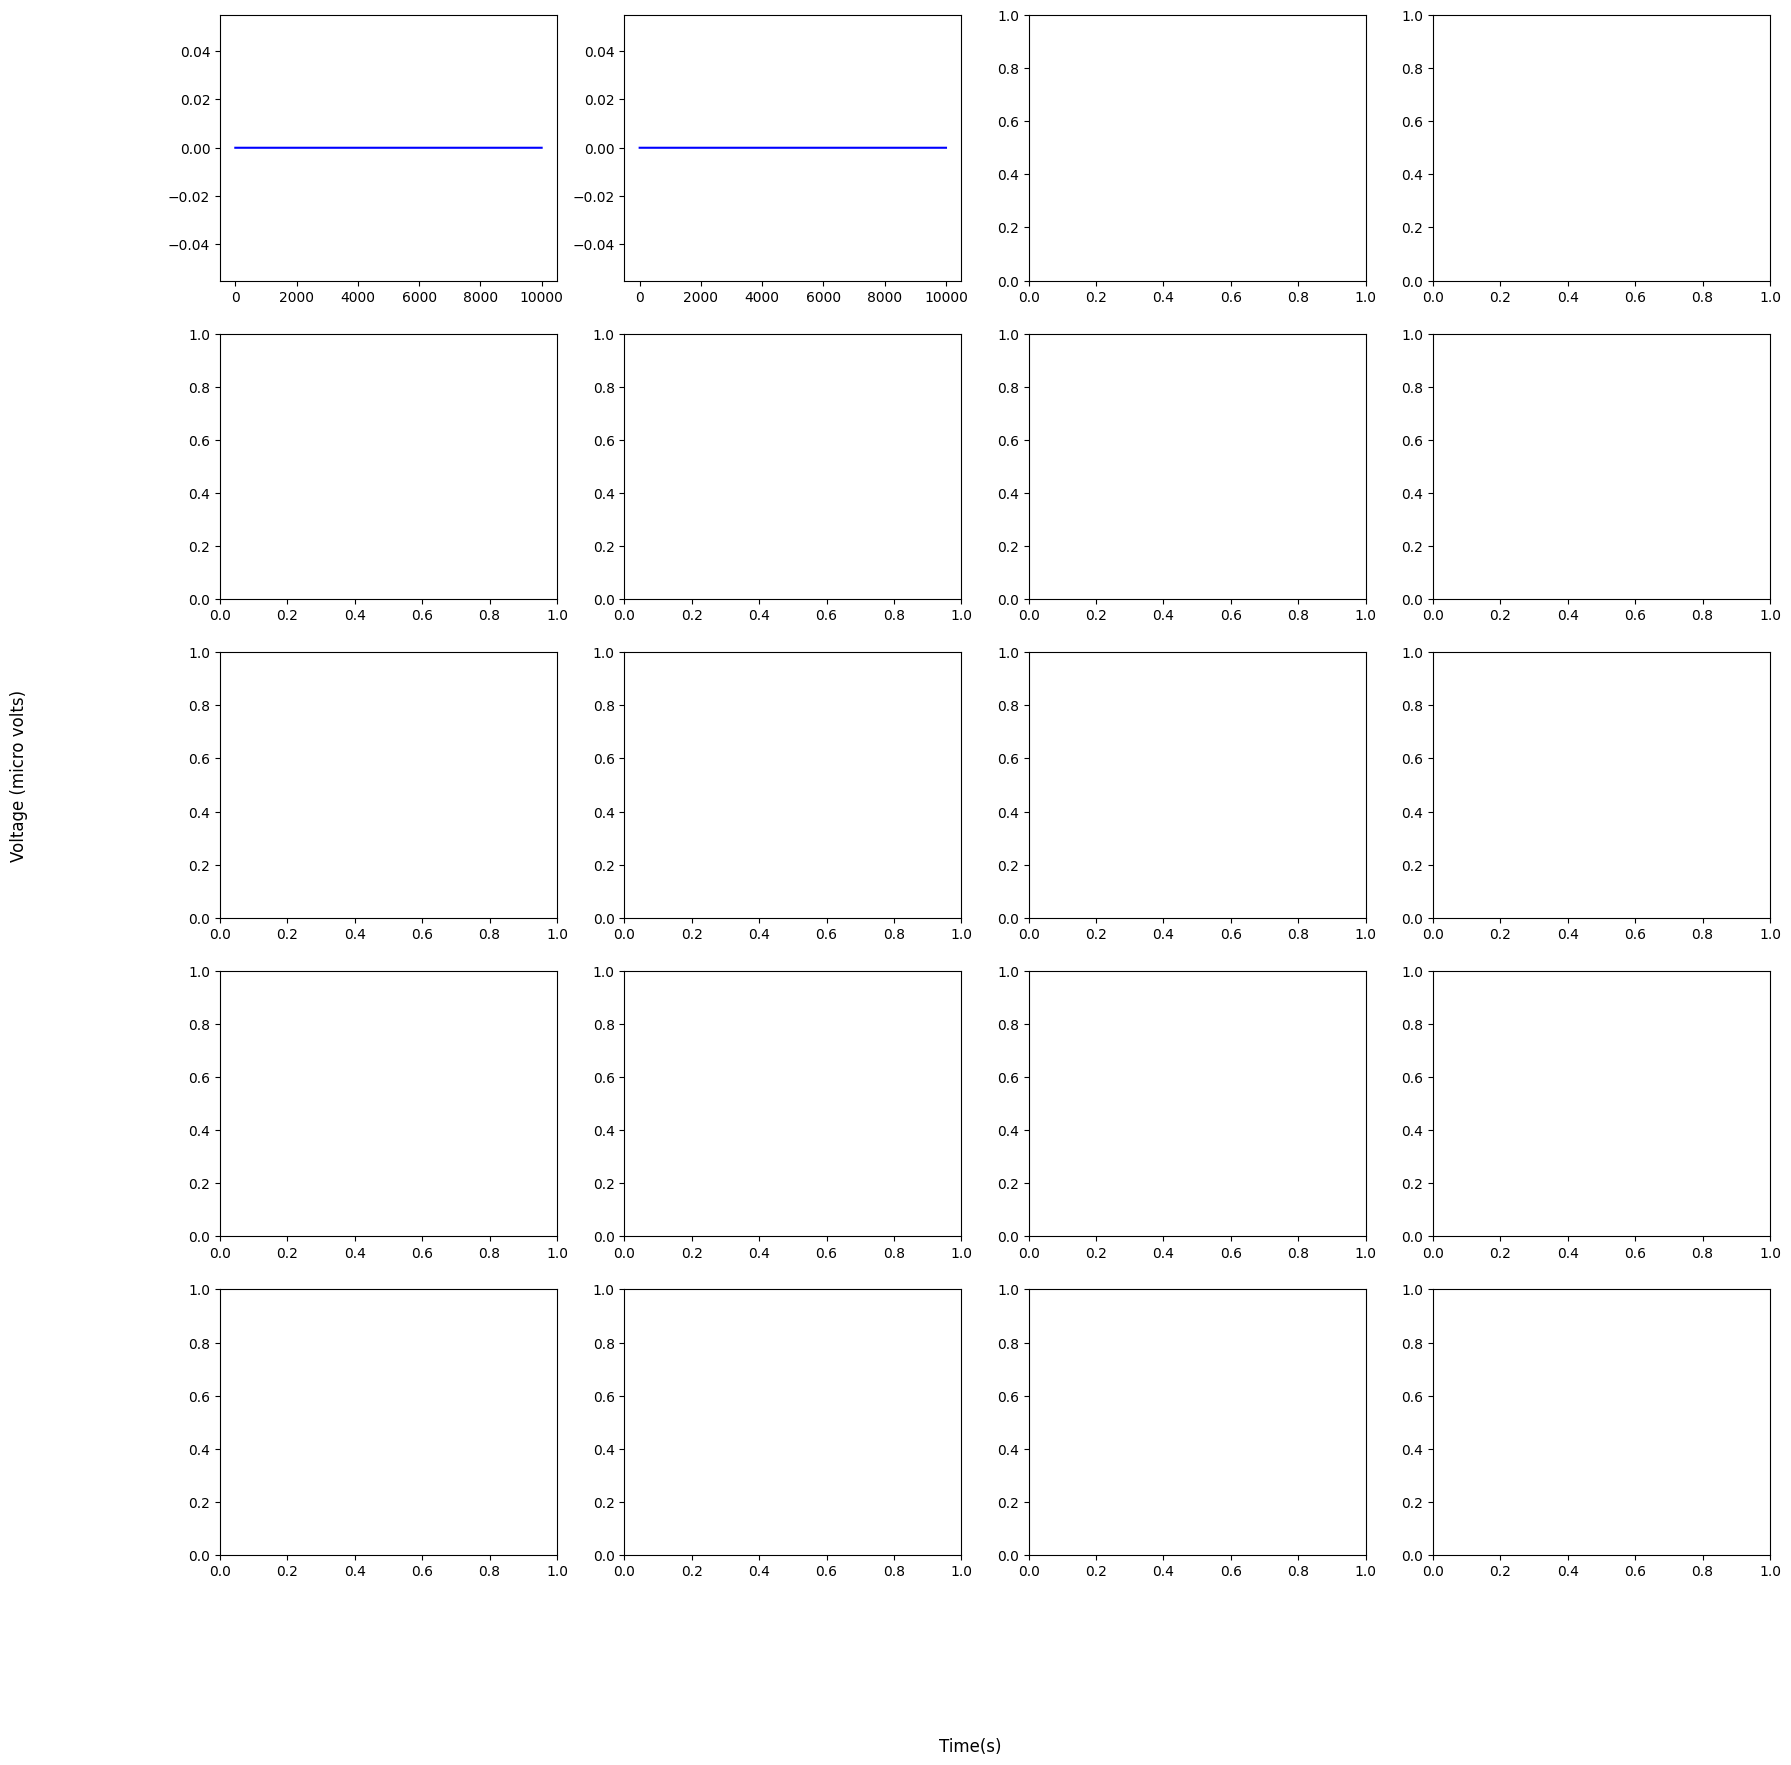

In [856]:
sin_wave1 = np.sin(2 * np.pi * 1 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 2 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 3 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 4 * np.arange(0, 100)) 

plt.plot(sin_wave1)
plt.show()

sin_wave2 = np.sin(2 * np.pi * 1 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 2 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 3 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 4 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 5 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 6 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 7 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 8 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 9 * np.arange(0, 100)) + \
    np.sin(2 * np.pi * 10 * np.arange(0, 100))

plt.plot(sin_wave2)
plt.show()

sin_wave = np.array([sin_wave1, sin_wave2])

sin_fft = fourier_transform_eeg(sin_wave, 4)
visualize_inverse_fourier(np.array(sin_fft))